In [119]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import numpy as np

### Dataset: VHM Historical Data

In [120]:
data = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)

data


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,68421.0,66541.0,68722.0,65789.0,1.05M,4.00%
2019-03-04,70075.0,69173.0,70300.0,67368.0,1.18M,2.42%
2019-03-05,68421.0,69323.0,69849.0,68045.0,1.50M,-2.36%
2019-03-06,69022.0,68421.0,69097.0,68270.0,770.13K,0.88%
2019-03-07,69173.0,69173.0,71654.0,69097.0,1.70M,0.22%
...,...,...,...,...,...,...
2024-05-27,39800.0,39850.0,40050.0,39750.0,4.62M,0.00%
2024-05-28,39950.0,39850.0,40050.0,39750.0,5.56M,0.38%
2024-05-29,39450.0,40000.0,40100.0,39450.0,8.03M,-1.25%


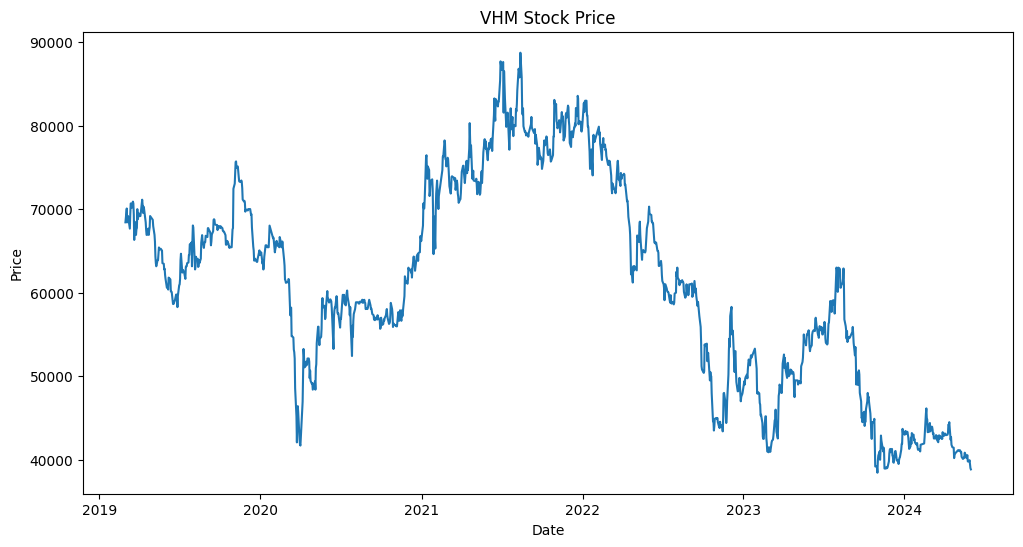

In [121]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data['Price'])
plt.title('VHM Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

#### Ratio 7:3

In [122]:
time_series = data['Price']

# Split data into train and test set
train_size = int(0.7 * len(time_series))
test_size = int(0.3 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size+test_size]

# Fit model
model = auto_arima(train_data, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
model.fit(train_data)

# Forecast
pred_test = model.predict(n_periods=len(test_data))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15691.484, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15686.443, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15688.129, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15688.117, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15684.835, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15690.052, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.931 seconds


c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 30 days

In [123]:
# Generate a range of dates for the next 30 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_30_days = np.array(next_30_days).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 60 days

In [124]:
# Generate a range of dates for the next 60 days
next_60_days = pd.date_range(start=data.index[-1], periods=60)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_60_days = np.array(next_60_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 90 days

In [125]:
# Generate a range of dates for the next 60 days
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


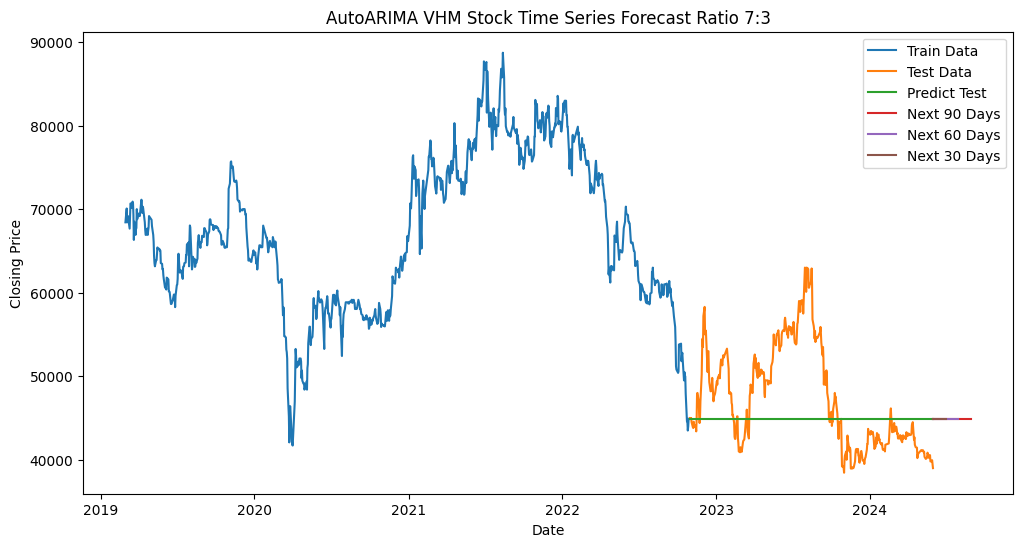

In [126]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Next 30 Days')
plt.title('AutoARIMA VHM Stock Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [127]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(pred_test - test_data))
print("Testing MAE:", test_mae)



Testing RMSE: 6636.3239195652895
Testing MAPE: 10.359563567636348
Testing MAE: 5212.086513994911


#### Ratio 8:2

In [128]:
time_series = data['Price']

# Split data into train and test set
train_size = int(0.8 * len(time_series))
test_size = int(0.2 * len(time_series))

train_data = time_series[:train_size+1]
test_data = time_series[train_size:train_size+test_size]

# Fit model
model = auto_arima(train_data, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
model.fit(train_data)

# Forecast
pred_test = model.predict(n_periods=len(test_data))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17947.188, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17943.889, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17944.901, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17944.865, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17942.062, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17946.693, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.678 seconds


c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 30 days

In [129]:
# Generate a range of dates for the next 30 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_30_days = np.array(next_30_days).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 60 days

In [130]:
# Generate a range of dates for the next 60 days
next_60_days = pd.date_range(start=data.index[-1], periods=60)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_60_days = np.array(next_60_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 90 days

In [131]:
# Generate a range of dates for the next 60 days
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


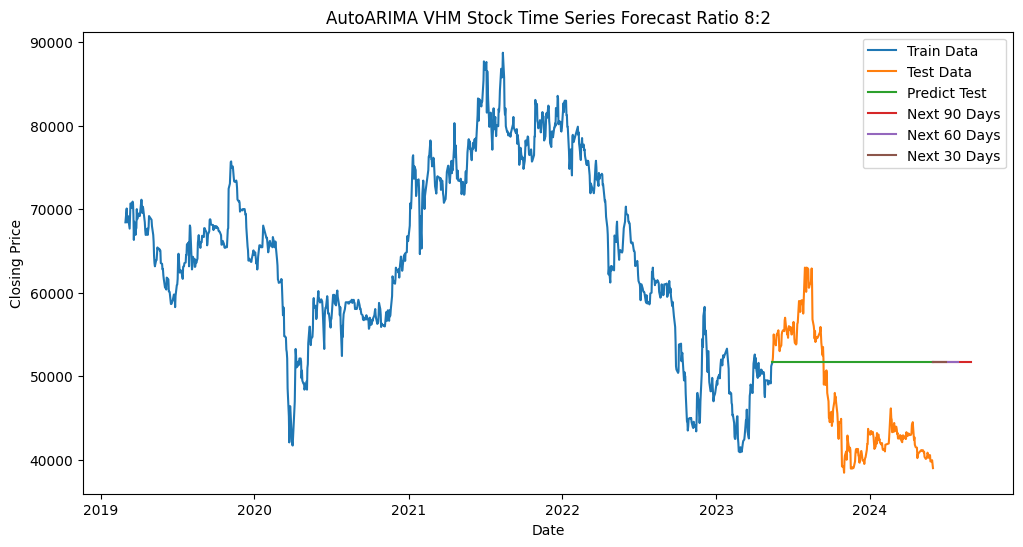

In [132]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Next 30 Days')
plt.title('AutoARIMA VHM Stock Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [133]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(pred_test - test_data))
print("Testing MAE:", test_mae)



Testing RMSE: 8432.211729818491
Testing MAPE: 17.508305597630716
Testing MAE: 7744.274809160305


#### Ratio 9:1

In [134]:
time_series = data['Price']

# Split data into train and test set
train_size = int(0.9 * len(time_series))
test_size = int(0.1 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size+test_size]

# Fit model
model = auto_arima(train_data, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
model.fit(train_data)

# Forecast
pred_test = model.predict(n_periods=len(test_data))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20154.355, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20150.993, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20151.303, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20151.234, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20149.398, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20152.988, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.495 seconds


c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 30 days

In [135]:
# Generate a range of dates for the next 30 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_30_days = np.array(next_30_days).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 60 days

In [136]:
# Generate a range of dates for the next 60 days
next_60_days = pd.date_range(start=data.index[-1], periods=60)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_60_days = np.array(next_60_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 90 days

In [137]:
# Generate a range of dates for the next 60 days
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


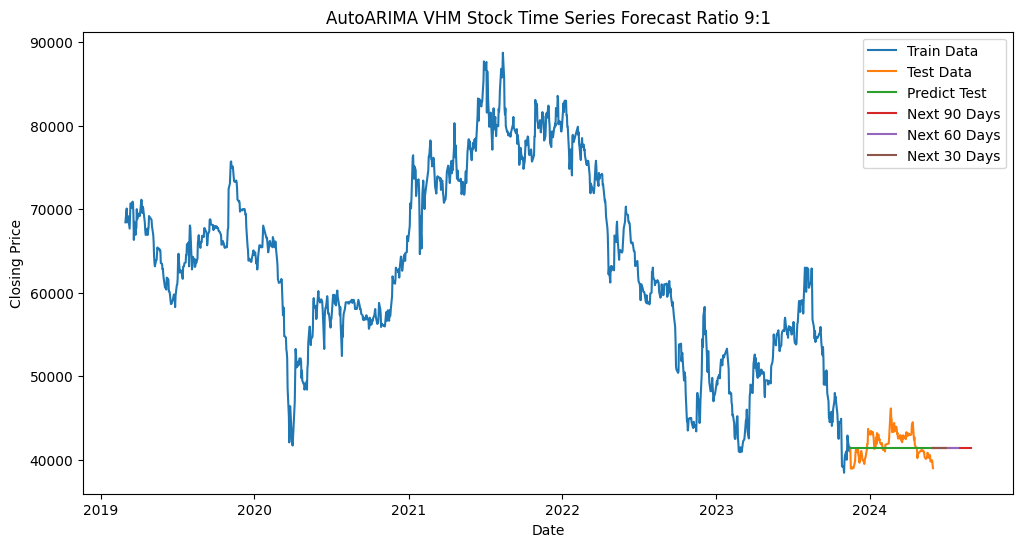

In [138]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Next 30 Days')
plt.title('AutoARIMA VHM Stock Time Series Forecast Ratio 9:1')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [139]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(pred_test - test_data))
print("Testing MAE:", test_mae)



Testing RMSE: 1577.7375336825958
Testing MAPE: 3.1428794723515994
Testing MAE: 1323.2824427480916


## Dataset: NVL Historical Data

In [140]:
data = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)

data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,32933.0,31765.0,32933.0,31765.0,891.22K,2.95%
2019-03-04,33100.0,32933.0,33378.0,32600.0,899.13K,0.51%
2019-03-05,32711.0,32989.0,33211.0,32544.0,963.79K,-1.18%
2019-03-06,31709.0,32711.0,32711.0,31487.0,1.58M,-3.06%
2019-03-07,31932.0,31709.0,32210.0,31709.0,849.59K,0.70%
...,...,...,...,...,...,...
2024-05-27,14500.0,14600.0,14600.0,14300.0,7.87M,0.35%
2024-05-28,14500.0,14500.0,14600.0,14350.0,11.43M,0.00%
2024-05-29,14150.0,14550.0,14550.0,14150.0,15.86M,-2.41%


#### Ratio 7:3

In [141]:
time_series = data['Price']

# Split data into train and test set
train_size = int(0.7 * len(time_series))
test_size = int(0.3 * len(time_series))

train_data = time_series[:train_size+1]
test_data = time_series[train_size:train_size+test_size]

# match the first value of test_data with the last value of train_data
# test_data = np.insert(test_data, 0, train_data[-1])

# Fit model
model = auto_arima(train_data, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

model.fit(train_data)

# Forecast
pred_test = model.predict(n_periods=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15226.133, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15233.860, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15222.961, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15222.506, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15233.481, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15224.470, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15224.445, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15226.334, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15221.704, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15223.679, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=15223.663, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=15222.127, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=15225.564, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.828 seconds


c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 30 days

In [142]:
# Generate a range of dates for the next 30 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_30_days = np.array(next_30_days).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 60 days

In [143]:
# Generate a range of dates for the next 60 days
next_60_days = pd.date_range(start=data.index[-1], periods=60)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_60_days = np.array(next_60_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 90 days

In [144]:
# Generate a range of dates for the next 60 days
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


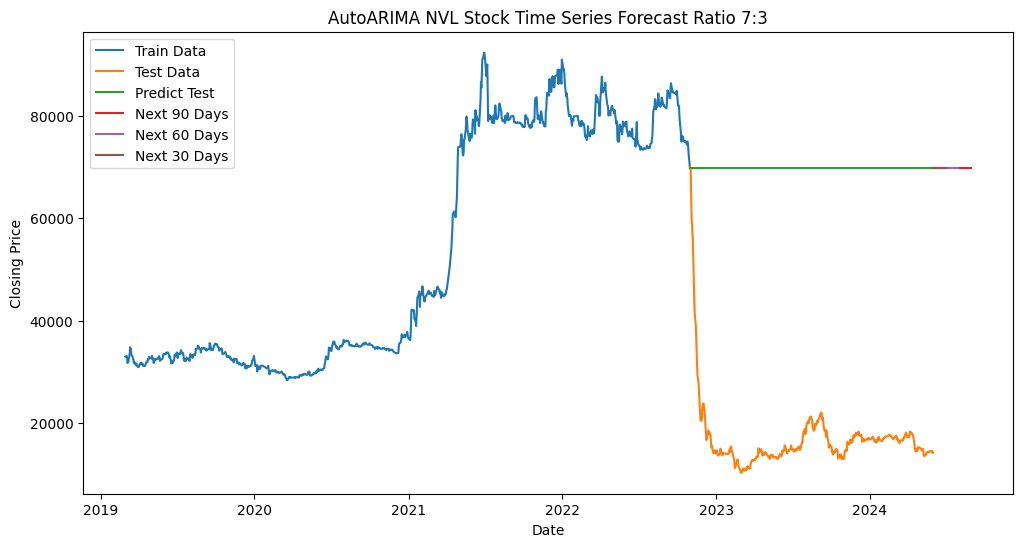

In [145]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Next 30 Days')
plt.title('AutoARIMA NVL Stock Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [146]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(pred_test - test_data))
print("Testing MAE:", test_mae)



Testing RMSE: 53244.740180208566
Testing MAPE: 344.1192588987465
Testing MAE: 52711.138504706454


#### Ratio 8:2

In [147]:
time_series = data['Price']

# Split data into train and test set
train_size = int(0.8 * len(time_series))
test_size = int(0.2 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size+test_size]

# Fit model
model = auto_arima(train_data, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

model.fit(train_data)

# Forecast
pred_test = model.predict(n_periods=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=17443.741, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=17863.381, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=17708.799, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=17498.552, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=17440.209, Time=0.25 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=17440.225, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=17439.053, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=17440.077, Time=0.23 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=17627.872, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=17440.893, Time=0.30 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.454 seconds


c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 30 days

In [148]:
# Generate a range of dates for the next 30 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_30_days = np.array(next_30_days).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 60 days

In [149]:
# Generate a range of dates for the next 60 days
next_60_days = pd.date_range(start=data.index[-1], periods=60)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_60_days = np.array(next_60_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 90 days

In [150]:
# Generate a range of dates for the next 60 days
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


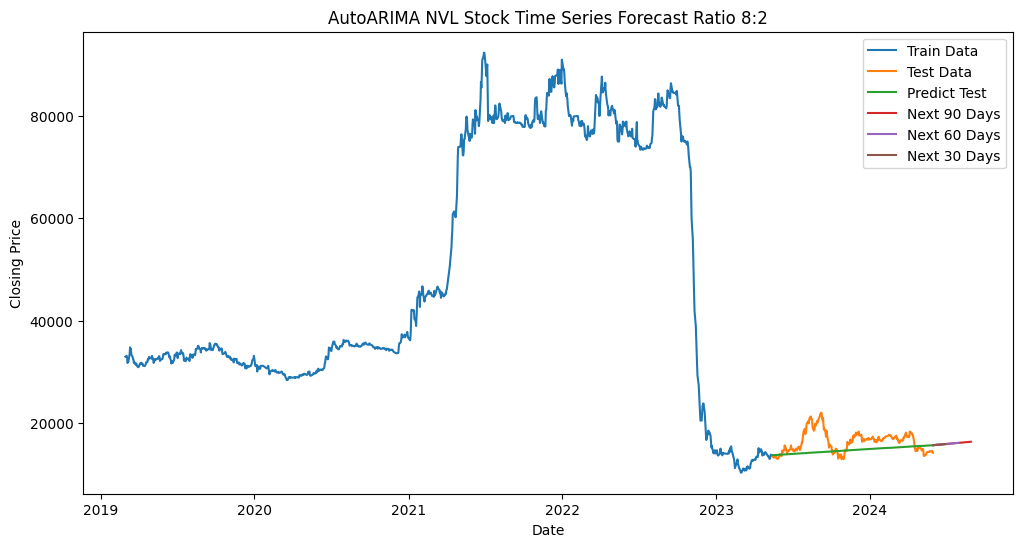

In [151]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Next 30 Days')
plt.title('AutoARIMA NVL Stock Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [152]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(pred_test - test_data))
print("Testing MAE:", test_mae)



Testing RMSE: 2639.903296008417
Testing MAPE: 11.587976107481907
Testing MAE: 2028.8891549026812


#### Ratio 9:1

In [153]:
time_series = data['Price']

# Split data into train and test set
train_size = int(0.9 * len(time_series))
test_size = int(0.1 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size+test_size]

# Fit model
model = auto_arima(train_data, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

model.fit(train_data)

# Forecast
pred_test = model.predict(n_periods=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=19528.309, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=20012.718, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=19831.093, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=19583.773, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=19524.696, Time=0.27 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=19524.590, Time=0.17 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=19524.626, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=19523.379, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=19524.602, Time=0.22 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=19738.411, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=19525.250, Time=0.33 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.677 seconds


c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 30 days

In [154]:
# Generate a range of dates for the next 30 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_30_days = np.array(next_30_days).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 60 days

In [155]:
# Generate a range of dates for the next 60 days
next_60_days = pd.date_range(start=data.index[-1], periods=60)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_60_days = np.array(next_60_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 90 days

In [156]:
# Generate a range of dates for the next 60 days
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


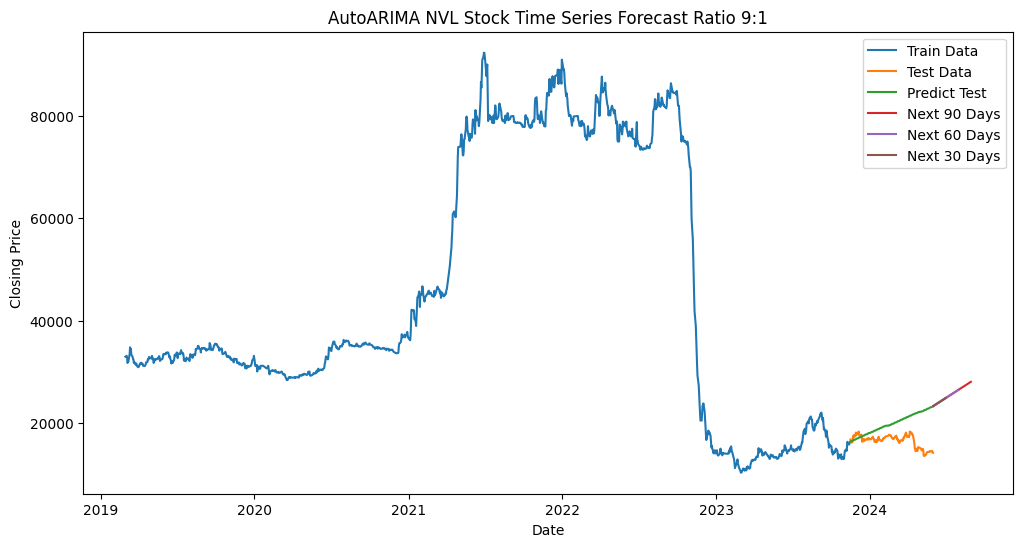

In [157]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Next 30 Days')
plt.title('AutoARIMA NVL Stock Time Series Forecast Ratio 9:1')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [158]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(pred_test - test_data))
print("Testing MAE:", test_mae)



Testing RMSE: 4400.474037617675
Testing MAPE: 22.333575849231032
Testing MAE: 3480.321314983883


## Dataset: NLG Historical Data

In [159]:
data = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)

data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,18706.8,18496.6,18776.9,18496.6,365.80K,1.14%
2019-03-04,19127.2,18706.8,19127.2,18636.7,1.08M,2.25%
2019-03-05,18917.0,19127.2,19127.2,18846.9,468.76K,-1.10%
2019-03-06,18846.9,18987.1,19057.1,18811.9,225.18K,-0.37%
2019-03-07,18706.8,18846.9,18987.1,18671.8,453.92K,-0.74%
...,...,...,...,...,...,...
2024-05-27,43900.0,43900.0,44200.0,43000.0,1.56M,0.00%
2024-05-28,43701.0,43404.0,44047.0,43108.0,2.20M,-0.45%
2024-05-29,44400.0,43900.0,44600.0,43500.0,2.84M,1.60%


#### Ratio 7:3

In [160]:
time_series = data['Price']

# Split data into train and test set
train_size = int(0.7 * len(time_series))
test_size = int(0.3 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size+test_size]

# Fit model
model = auto_arima(train_data, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

model.fit(train_data)

# Forecast
pred_test = model.predict(n_periods=len(test_data))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15099.910, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15104.294, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15106.067, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15106.054, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15102.315, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15108.107, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15107.736, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=15096.764, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15103.473, Time=0.20 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=15098.667, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=15098.778, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=15097.057, Time=0.28 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=15101.070, Time=0.17 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(3,1,2)(0,0,0)[0]  

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 30 days

In [161]:
# Generate a range of dates for the next 30 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_30_days = np.array(next_30_days).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 60 days

In [162]:
# Generate a range of dates for the next 60 days
next_60_days = pd.date_range(start=data.index[-1], periods=60)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_60_days = np.array(next_60_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 90 days

In [163]:
# Generate a range of dates for the next 60 days
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


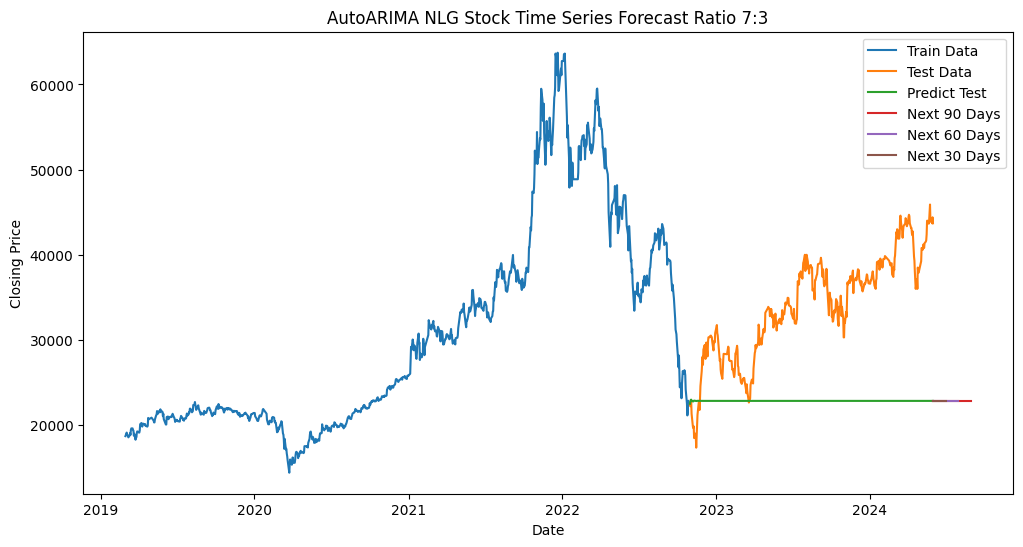

In [164]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Next 30 Days')
plt.title('AutoARIMA NLG Stock Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [165]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(pred_test - test_data))
print("Testing MAE:", test_mae)



Testing RMSE: 12685.641532608835
Testing MAPE: 31.31145920773798
Testing MAE: 11342.469813361602


#### Ratio 8:2

In [166]:
time_series = data['Price']

# Split data into train and test set
train_size = int(0.8 * len(time_series))
test_size = int(0.2 * len(time_series))

train_data = time_series[:train_size+1]
test_data = time_series[train_size:train_size+test_size]

# Fit model
model = auto_arima(train_data, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

model.fit(train_data)

# Forecast
pred_test = model.predict(n_periods=len(test_data))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17270.890, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17269.308, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17271.299, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17271.304, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17267.535, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17273.299, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.661 seconds


c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 30 days

In [167]:
# Generate a range of dates for the next 30 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_30_days = np.array(next_30_days).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 60 days

In [168]:
# Generate a range of dates for the next 60 days
next_60_days = pd.date_range(start=data.index[-1], periods=60)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_60_days = np.array(next_60_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 90 days

In [169]:
# Generate a range of dates for the next 60 days
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


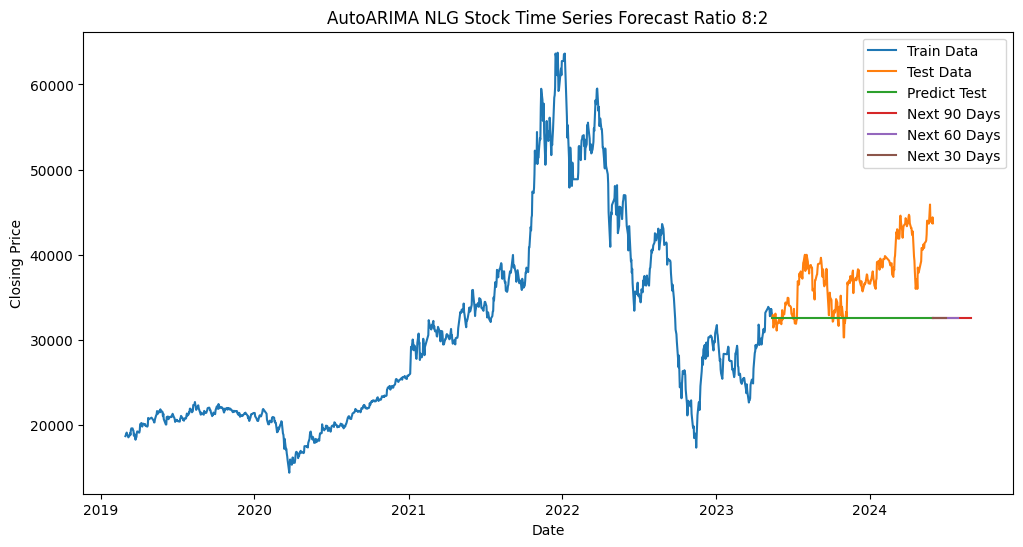

In [170]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Next 30 Days')
plt.title('AutoARIMA NLG Stock Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [171]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(pred_test - test_data))
print("Testing MAE:", test_mae)



Testing RMSE: 6037.703786328903
Testing MAPE: 12.54043099528143
Testing MAE: 4970.721374045802


#### Ratio 9:1

In [172]:
time_series = data['Price']

# Split data into train and test set
train_size = int(0.9 * len(time_series))
test_size = int(0.1 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size+test_size]

# Fit model
model = auto_arima(train_data, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

model.fit(train_data)

# Forecast
pred_test = model.predict(n_periods=len(test_data))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19433.219, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19429.802, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19431.777, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19431.780, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19428.134, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.599 seconds


c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 30 days

In [173]:
# Generate a range of dates for the next 30 days
next_30_days = pd.date_range(start=data.index[-1], periods=30)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_30_days = np.array(next_30_days).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days) + len(test_data))[-30:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 60 days

In [174]:
# Generate a range of dates for the next 60 days
next_60_days = pd.date_range(start=data.index[-1], periods=60)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_60_days = np.array(next_60_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_60_days = model.predict(n_periods=len(x_next_60_days) + len(test_data))[-60:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast 90 days

In [175]:
# Generate a range of dates for the next 60 days
next_90_days = pd.date_range(start=data.index[-1], periods=90)

# Convert the date range to a NumPy array if needed for your prediction model
x_next_90_days = np.array(next_90_days).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days) + len(test_data))[-90:]

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


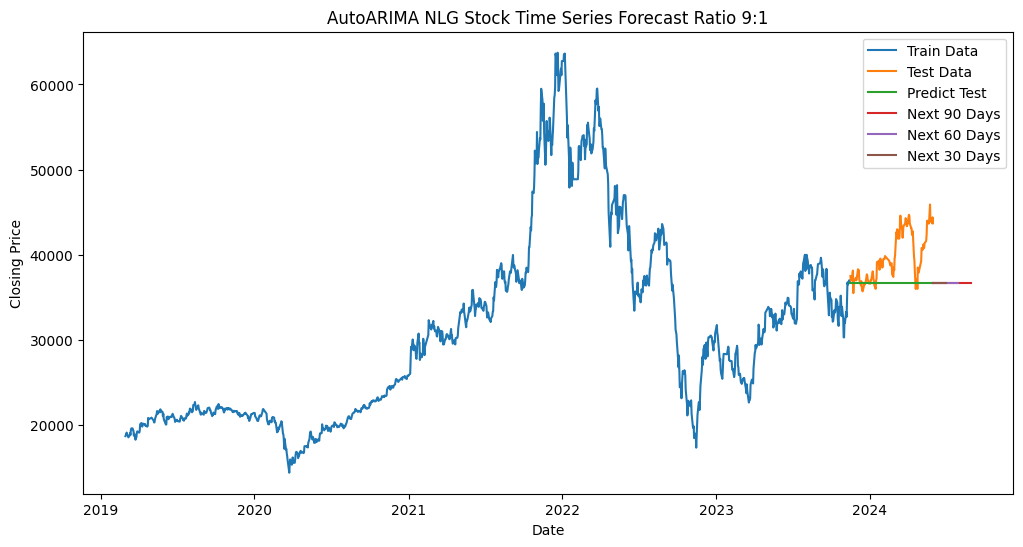

In [176]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.plot(next_90_days, y_next_90_days, label='Next 90 Days')
plt.plot(next_60_days, y_next_60_days, label='Next 60 Days')
plt.plot(next_30_days, y_next_30_days, label='Next 30 Days')
plt.title('AutoARIMA NLG Stock Time Series Forecast Ratio 9:1')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [177]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data.values if isinstance(test_data, pd.Series) else test_data

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((test_data - pred_test) / test_data)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(pred_test - test_data))
print("Testing MAE:", test_mae)



Testing RMSE: 4232.403176548161
Testing MAPE: 7.67626549206654
Testing MAE: 3230.5419847328244
